In [1]:
################################################################################
########################          Yelp Reviews          ######################## 
########################    Classification : Xgboost    ######################## 
########################  Stars on Reviews: 1 & 2 vs 5  ########################
################################################################################

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install gensim==3.8.3
!pip install xgboost==1.5.2
!pip install optuna
import os
import random
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import multiprocessing
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import xgboost as xgb
from xgboost import XGBClassifier
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
import joblib
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

my_dpi=96

     |████████████████████████████████| 24.2 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 173.6 MB 7.1 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
     |████████████████████████████████| 308 kB 4.1 MB/s 
     |████████████████████████████████| 210 kB 80.8 MB/s 
     |████████████████████████████████| 81 kB 12.2 MB/s 
     |████████████████████████████████| 78 kB 9.9 MB/s 
     |████████████████████████████████| 49 kB 8.5 MB/s 
     |████████████████████████████████| 112 kB 96.9 MB/s 
     |████████████████████████████████| 146 kB 91.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=a6cda8156572c748d8dc17604f470b8f7e616083870f6d4b64b4d73ca1b72032
  Stored in directory:

In [4]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Fri May 13 21:39:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|            

In [5]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [6]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [7]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1541486, 2)


,stars_reviews,cleanReview
index,,
2,5.0,"[wonderful, place, get, lunch, staff, friendly..."
3,5.0,"[dedicated, loving, memory, gary, feldman, gre..."
5,5.0,"[love, place, everything, menu, delicious, lik..."
7,5.0,"[truely, hidden, gem, place, greatest, buffalo..."
9,5.0,"[seriously, great, fresh, fantastic, food, spo..."


In [8]:
# Process format of reviews for word2vec
df = df.copy()
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

,stars_reviews,cleanReview
index,,
2,5.0,"[""wonderful"", ""place"", ""get"", ""lunch"", ""staff""..."
3,5.0,"[""dedicated"", ""loving"", ""memory"", ""gary"", ""fel..."
5,5.0,"[""love"", ""place"", ""everything"", ""menu"", ""delic..."
7,5.0,"[""truely"", ""hidden"", ""gem"", ""place"", ""greatest..."
9,5.0,"[""seriously"", ""great"", ""fresh"", ""fantastic"", ""..."


In [9]:
# Recode to binary
df = df.copy()
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

print('Number of reviews per group:')
df[['stars_reviews']].value_counts() 

Number of reviews per group:


stars_reviews
0.0              770743
1.0              770743
dtype: int64

In [10]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

In [11]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [12]:
# Load model
word2vec_path = 'gensim_w2vModel_review125_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [13]:
# Save embedded word vector space
wv = model.wv
print(len(wv.vocab),'unique words in the dataset.')

373847 unique words in the dataset.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [14]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for review documents. 
    This is done in the transform function which is used to generate mean vectors in model pipelines.
    The class has both fit and transform functions so that it may be used in an sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        #If using GloVe the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        #Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Need to implement a fit method as required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        This function generates a w2v vector for a set of tokens. This is done by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [15]:
print('Pipeline for Word2Vec:')
pl  = Pipeline([("W2vVectorizer", W2vVectorizer(wv))])
pl

Pipeline for Word2Vec:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7f4344c74690>)])

In [16]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_PKL


In [17]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value
    )

    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  
    run_time = timer() - start

    return np.mean(cv_scores)       

In [18]:
################################################################################
######################     Xgboost Optuna HPO   ################################
######################         100 trials       ################################
################################################################################
def xgb_hpo(trial):
    """
    Objective function to tune a `XgboostClassifier` model.
    """
    joblib.dump(study, 'Xgboost_Optuna_100_GPU_balancedSizeSentiment.pkl')

    # Define parameter grid
    params_xgboost_optuna = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
    'max_depth': trial.suggest_int('max_depth', 3, 10),

    'subsample': trial.suggest_uniform('subsample', 0, 1),

    'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
    'reg_alpha' : trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
    'reg_lambda' : trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),

    'colsample_bytree' : trial.suggest_uniform('colsample_bytree', 0, 1),

    'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel', 0, 1), 

    'min_child_weight' : trial.suggest_int('min_child_weight', 0, 10),
    }



    model = XGBClassifier(
        objective='binary:logistic',
        n_jobs=-1,
        random_state=seed_value,
        booster='gbtree',  
        tree_method='gpu_hist', 
        scale_pos_weight=1,
        use_label_encoder=False,
        verbosity=0,
        **params_xgboost_optuna,
    )
    
    return train_model_for_study(features, label, model)

In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
if os.path.isfile('Xgboost_Optuna_100_GPU_balancedSizeSentiment.pkl'):
    study = joblib.load('Xgboost_Optuna_100_GPU_balancedSizeSentiment.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(xgb_hpo, n_trials=23)

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
[182]	validation_0-logloss:0.15653
[183]	validation_0-logloss:0.15652
[184]	validation_0-logloss:0.15650
[185]	validation_0-logloss:0.15647
[186]	validation_0-logloss:0.15645
[187]	validation_0-logloss:0.15643
[188]	validation_0-logloss:0.15639
[189]	validation_0-logloss:0.15636
[190]	validation_0-logloss:0.15634
[191]	validation_0-logloss:0.15632
[192]	validation_0-logloss:0.15631
[193]	validation_0-logloss:0.15630
[194]	validation_0-logloss:0.15628
[195]	validation_0-logloss:0.15626
[196]	validation_0-logloss:0.15624
[197]	validation_0-logloss:0.15622
[198]	validation_0-logloss:0.15618
[199]	validation_0-logloss:0.15616
[200]	validation_0-logloss:0.15616
[201]	validation_0-logloss:0.15615
[202]	validation_0-logloss:0.15612
[203]	validation_0-logloss:0.15610
[204]	validation_0-logloss:0.15610
[205]	validation_0-logloss:0.15609
[206]	validation_0-logloss:0.15608
[207]	validation_0-logloss:0.15607
[208]	validation_0-logloss:0.15604
[209

In [20]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/trialOptions/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/trialOptions


In [21]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'logloss'},inplace=True)
trials_df.rename(columns={'params_colsample_bylevel':'colsample_bylevel'}, inplace=True)
trials_df.rename(columns={'params_colsample_bytree':'colsample_bytree'}, inplace=True)
trials_df.rename(columns={'params_gamma':'gamma'}, inplace=True)
trials_df.rename(columns={'params_learning_rate':'learning_rate'}, inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_weight':'min_child_weight'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_reg_alpha':'reg_alpha'}, inplace=True)
trials_df.rename(columns={'params_reg_lambda':'reg_lambda'}, inplace=True)
trials_df.rename(columns={'params_subsample':'subsample'}, inplace=True)

trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Xgboost_Optuna_100_GPU_balancedSizeSentiment.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
78         78  0.154282 2022-05-13 19:16:09.162821 2022-05-13 19:20:11.915558   
95         95  0.154339 2022-05-13 20:22:40.363653 2022-05-13 20:26:38.169769   
77         77  0.154382 2022-05-13 19:12:04.341358 2022-05-13 19:16:09.162622   
79         79  0.154409 2022-05-13 19:20:11.915723 2022-05-13 19:24:13.117220   
68         68  0.154559 2022-05-13 18:19:35.156929 2022-05-13 18:22:40.276052   
..        ...       ...                        ...                        ...   
59         59  0.668598 2022-05-13 17:52:38.210095 2022-05-13 17:55:45.353154   
5           5  0.680436 2022-05-13 13:48:26.150103 2022-05-13 13:51:10.788783   
49         49       NaN 2022-05-13 15:47:21.221154                        NaT   
76         76       NaN 2022-05-13 18:44:12.181467                        NaT   
99         99       NaN 2022-05-13 20:37:56.378443                        NaT   

                 duration  

In [22]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_Explanations


In [23]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Xgboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [24]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Xgboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [25]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Xgboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [26]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_child_weight', 
                                                       'max_depth', 
                                                       'learning_rate', 
                                                       'gamma'])
py.plot(fig, filename='contour_Xgboost_Optuna_100_GPU.html')
fig.show()

In [27]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/trialOptions/

# Access results
trials_df = pd.read_csv('Xgboost_Optuna_100_GPU_balancedSizeSentiment.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/trialOptions


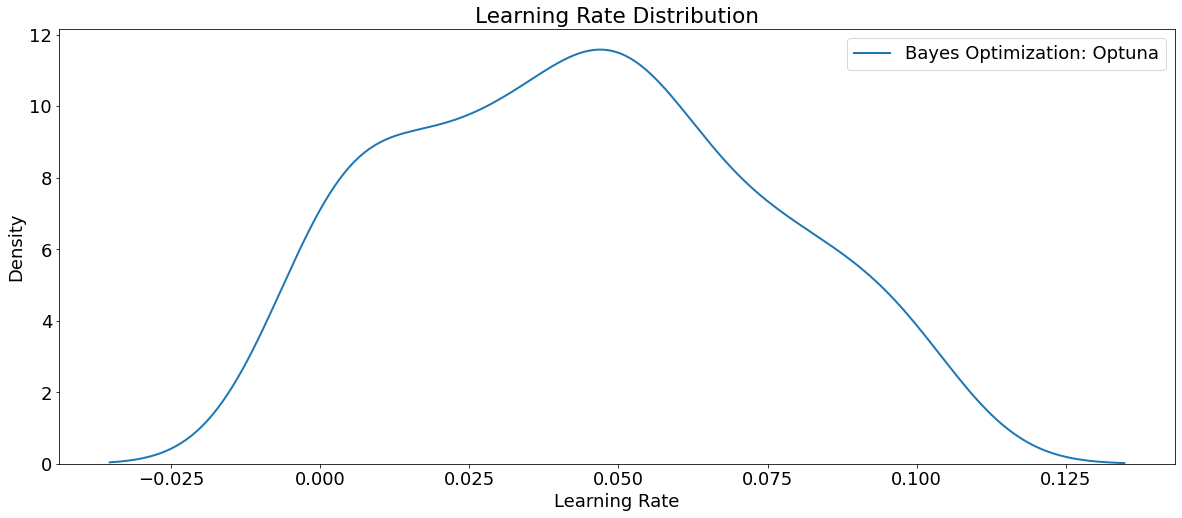

In [28]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label = 'Bayes Optimization: Optuna', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

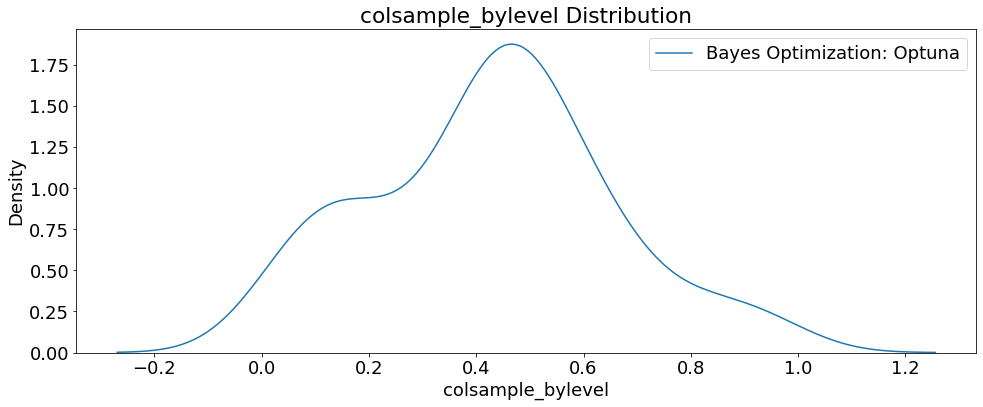

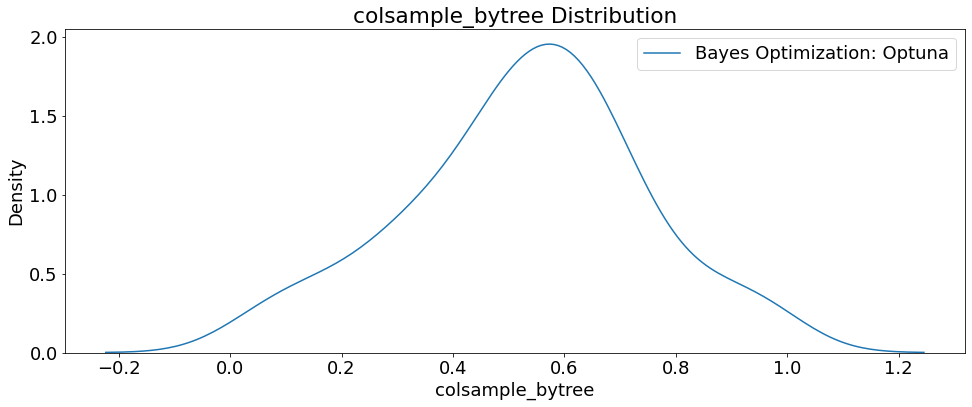

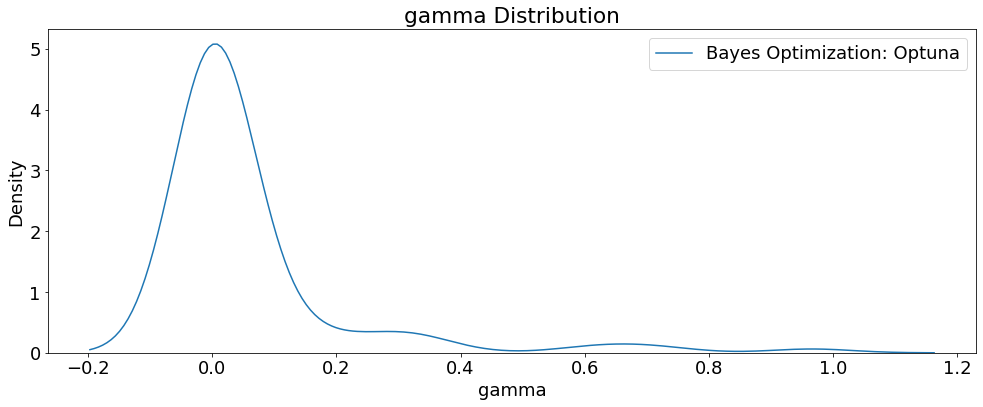

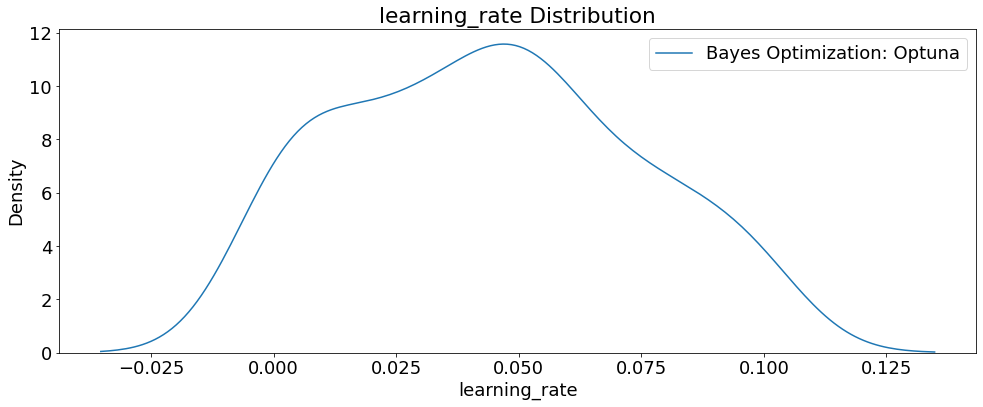

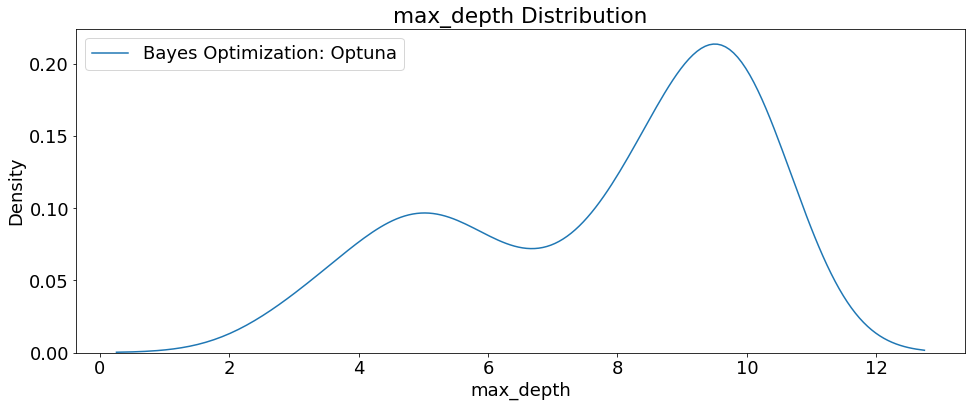

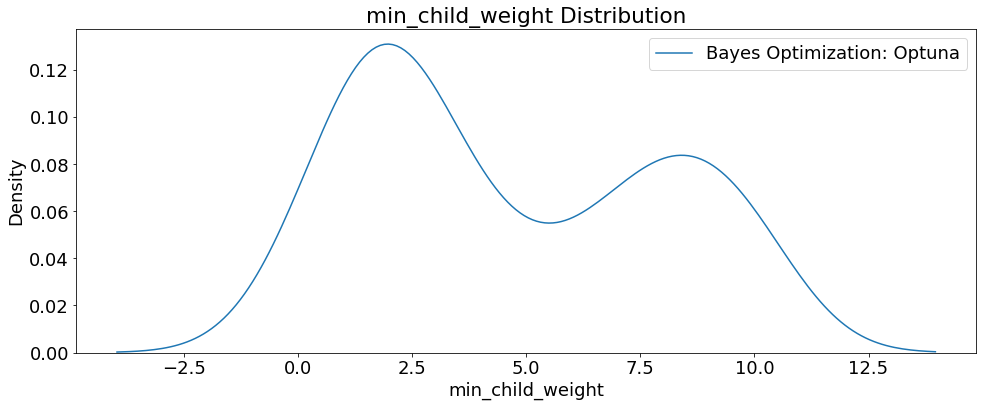

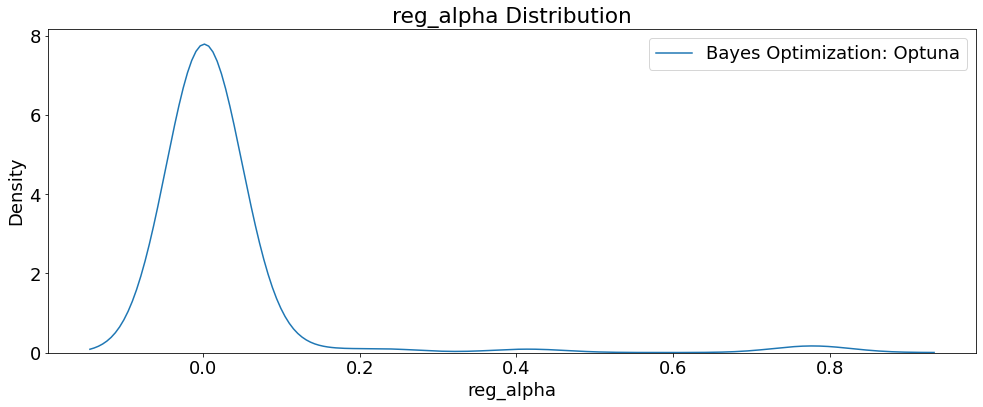

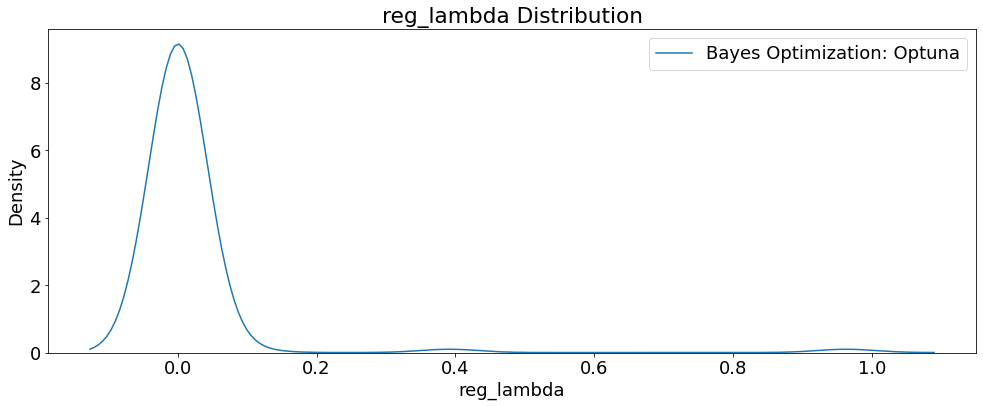

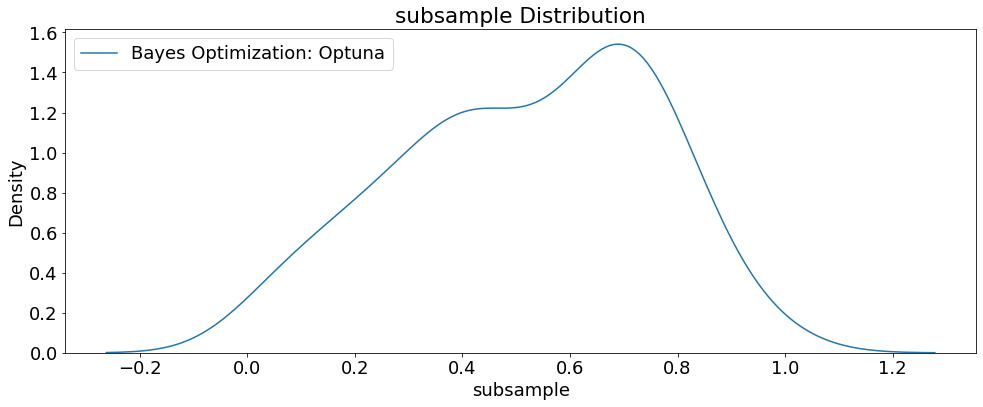

In [29]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning

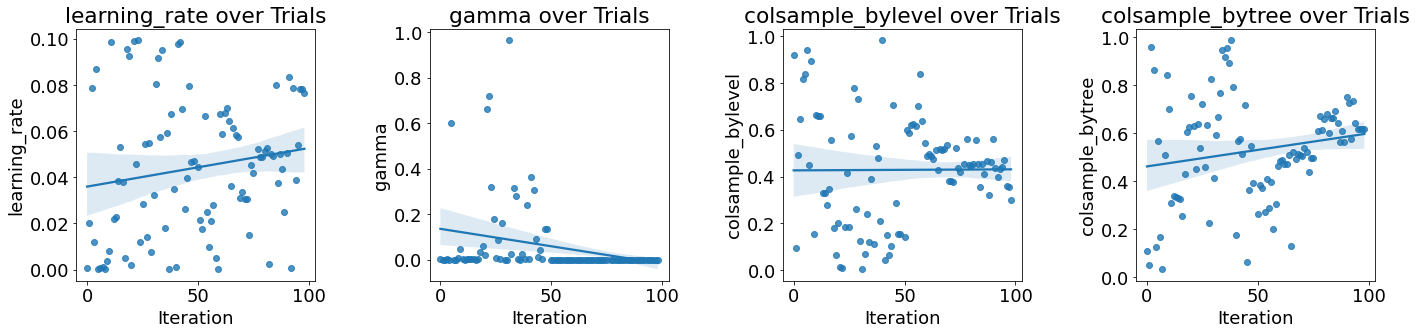

In [30]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



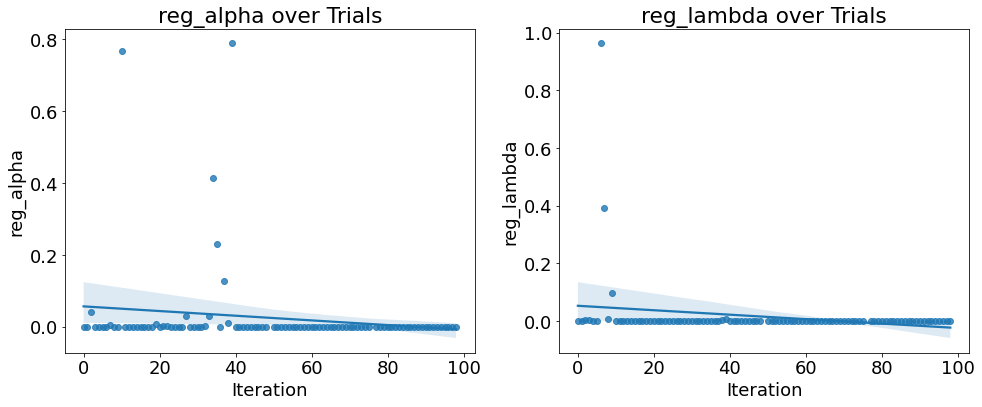

In [31]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize = (14, 6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [32]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_Explanations


In [33]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Xgboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [34]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Xgboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [35]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'colsample_bylevel': 0.5609575164766105,
 'colsample_bytree': 0.6708216097119821,
 'gamma': 1.524046899910265e-07,
 'learning_rate': 0.048644408861371564,
 'loss_function': 'Logloss',
 'max_depth': 10,
 'min_child_weight': 2,
 'n_estimators': 440,
 'random_state': 42,
 'reg_alpha': 2.2809581780376943e-08,
 'reg_lambda': 1.9058731720236959e-06,
 'subsample': 0.6867757219329979}

In [36]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_PKL/


study = joblib.load('Xgboost_Optuna_100_GPU_balancedSizeSentiment.pkl')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_PKL


In [37]:
label = df[['stars_reviews']]

features = df.cleanReview

In [38]:
# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, stratify=label)

In [39]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [40]:
# Re-create the best model and train on the training data
best_model = xgb.XGBClassifier(objective='binary:logistic',
                                                booster='gbtree',
                                                tree_method='gpu_hist', 
                                                scale_pos_weight=1,
                                                use_label_encoder=False,
                                                verbosity=0,
                                                n_jobs=-1, 
                                                **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Xgboost_HPO_Optuna_trials100_GPU_balancedSizeSentiment.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Xgboost_HPO_Optuna_trials100_GPU_balancedSizeSentiment.pkl')
# print(model)
# =============================================================================

In [41]:
print('Results from Xgboost HPO Optuna 100 GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')

print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Xgboost HPO Optuna 100 GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    616594
         1.0       0.96      0.96      0.96    616594

    accuracy                           0.96   1233188
   macro avg       0.96      0.96      0.96   1233188
weighted avg       0.96      0.96      0.96   1233188



Confusion matrix: Train
[[591254  25340]
 [ 27041 589553]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94    154149
         1.0       0.94      0.94      0.94    154149

    accuracy                           0.94    308298
   macro avg       0.94      0.94      0.94    308298
weighted avg       0.94      0.94      0.94    308298



Confusion matrix: Test
[[145017   9132]
 [  9471 144678]]


Accuracy score: train: 0.958, test: 0.940
Precision score: train: 0.959, test: 0.941
Recall score: train: 0.956, t

In [42]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/trialOptions/

# Access results
trials_df = pd.read_csv('Xgboost_Optuna_100_GPU_balancedSizeSentiment.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/trialOptions


In [43]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93966 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    78
logloss                                0.154282
datetime_start       2022-05-13 19:16:09.162821
datetime_complete    2022-05-13 19:20:11.915558
duration                 0 days 00:04:02.752737
colsample_bylevel                      0.560958
colsample_bytree                       0.670822
gamma                                       0.0
learning_rate                          0.048644
max_depth                                  10.0
min_child_weight                            2.0
n_estimators                              440.0
reg_alpha                                   0.0
reg_lambda                             0.000002
subsample                              0.686776
state                                  COMPLETE
Name: 0, dtype: object
